In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                            classification_report, roc_curve)
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')


#  for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# random seed for reproducibility
np.random.seed(42)


Dataset Shape: (10000, 50)

First 5 rows:
   CaseOrder Customer_id                           Interaction  \
0          1     K409198  aa90260b-4141-4a24-8e36-b04ce1f4f77b   
1          2     S120509  fb76459f-c047-4a9d-8af9-e0f7d4ac2524   
2          3     K191035  344d114c-3736-4be5-98f7-c72c281e2d35   
3          4      D90850  abfa2b40-2d43-4994-b15a-989b8c79e311   
4          5     K662701  68a861fd-0d20-4e51-a587-8a90407ee574   

                                UID         City State                 County  \
0  e885b299883d4f9fb18e39c75155d990  Point Baker    AK  Prince of Wales-Hyder   
1  f2de8bef964785f41a2959829830fb8a  West Branch    MI                 Ogemaw   
2  f1784cfa9f6d92ae816197eb175d3c71      Yamhill    OR                Yamhill   
3  dc8a365077241bb5cd5ccd305136b05e      Del Mar    CA              San Diego   
4  aabb64a116e83fdc4befc1fbab1663f9    Needville    TX              Fort Bend   

     Zip       Lat        Lng  ...  MonthlyCharge Bandwidth_GB_Year Item1 

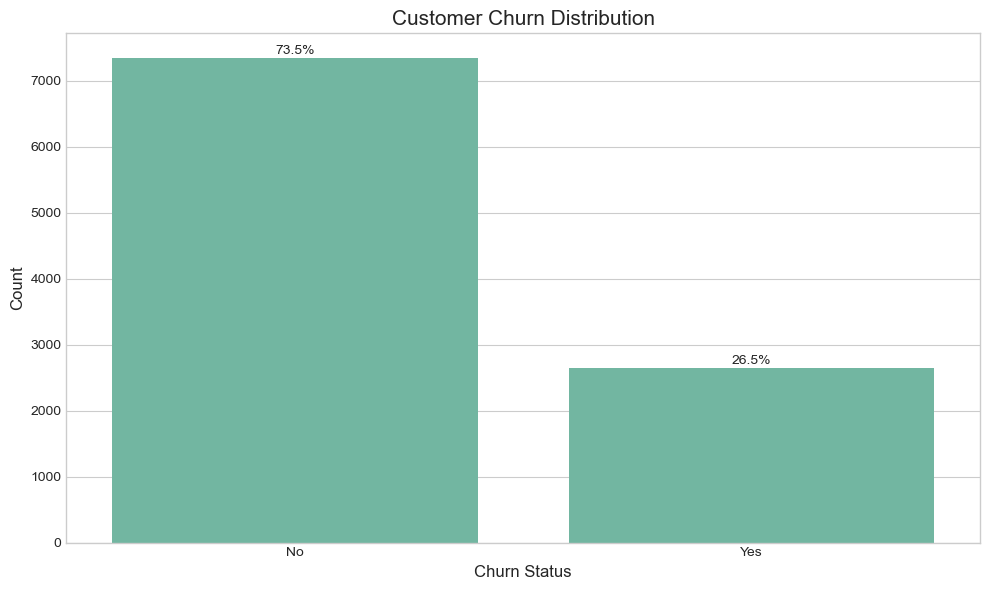

In [2]:


# load  dataset
df = pd.read_csv('churn_clean.csv')

#  dataset examination
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum().sum())

print("\nChurn Distribution:")
churn_counts = df['Churn'].value_counts()
print(churn_counts)
print(f"Churn Rate: {churn_counts['Yes'] / len(df) * 100:.2f}%")

# visualize Churn Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=df)
plt.title('Customer Churn Distribution', fontsize=15)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

# add percentages on top of bars
total = len(df)
for p in plt.gca().patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 50
    plt.gca().annotate(percentage, (x, y), ha='center')

plt.tight_layout()
plt.show()


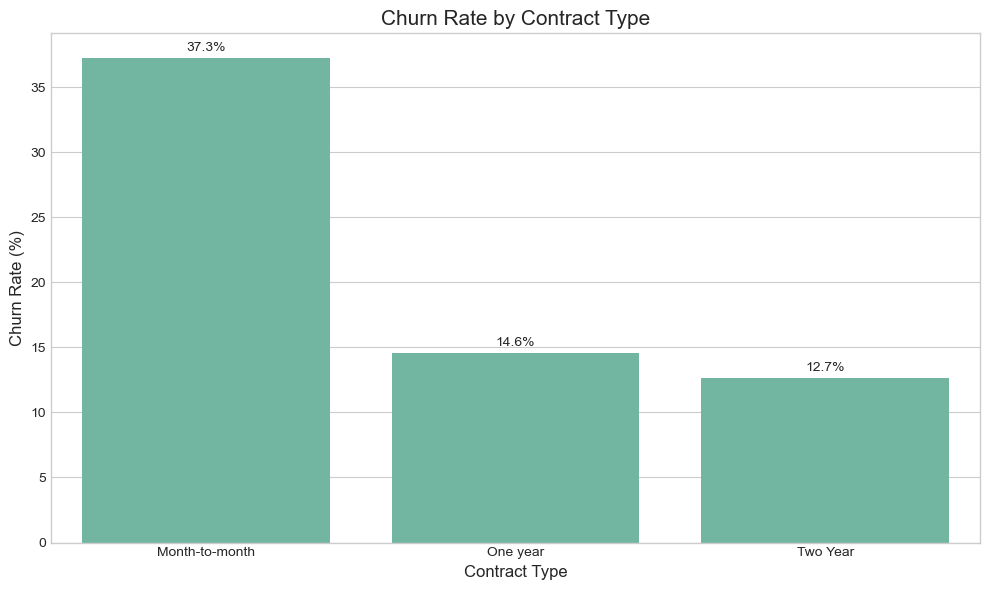

         Contract  Churn Rate (%)
0  Month-to-month       37.280059
1        One year       14.605138
2        Two Year       12.653563


In [3]:
# analyze relationship between contract type and churn
contract_churn = df.groupby('Contract')['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100
).reset_index()
contract_churn.columns = ['Contract', 'Churn Rate (%)']


plt.figure(figsize=(10, 6))
sns.barplot(x='Contract', y='Churn Rate (%)', data=contract_churn)
plt.title('Churn Rate by Contract Type', fontsize=15)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

# Add values on top of bars
for i, v in enumerate(contract_churn['Churn Rate (%)']):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

print(contract_churn)




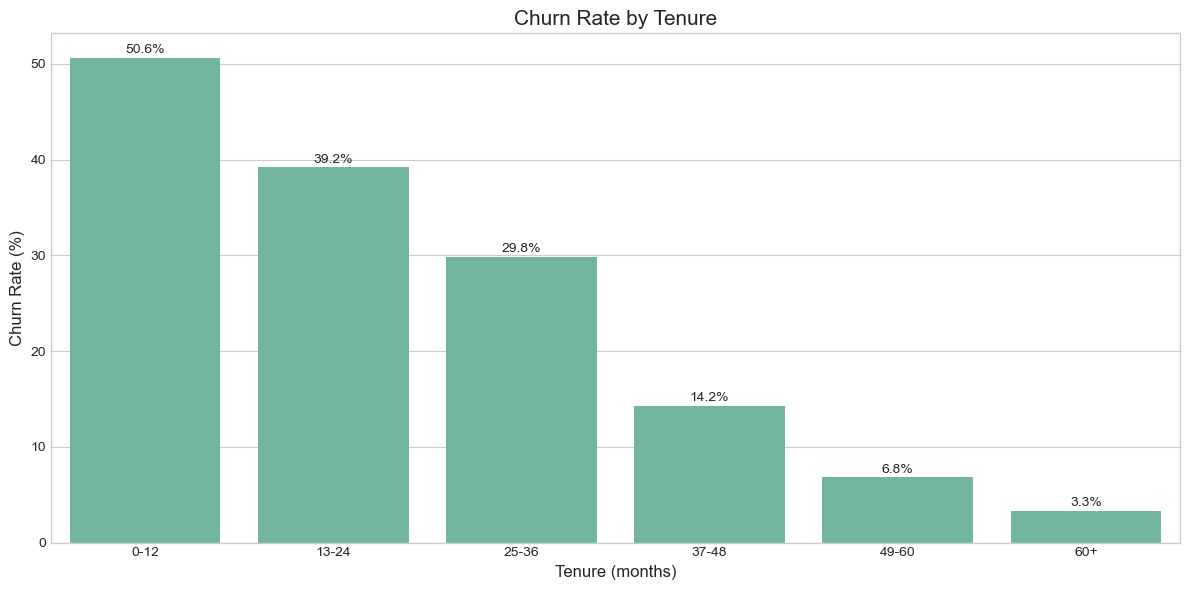

  Tenure (months)  Churn Rate (%)
0            0-12       50.645073
1           13-24       39.185954
2           25-36       29.807692
3           37-48       14.234875
4           49-60        6.797306
5             60+        3.279857


In [4]:

# Create tenure bins
df['TenureBin'] = pd.cut(
    df['Tenure'], 
    bins=[0, 12, 24, 36, 48, 60, float('inf')],
    labels=['0-12', '13-24', '25-36', '37-48', '49-60', '60+']
)

# Calculate churn rate by tenure bin
tenure_churn = df.groupby('TenureBin')['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100
).reset_index()
tenure_churn.columns = ['Tenure (months)', 'Churn Rate (%)']

plt.figure(figsize=(12, 6))
sns.barplot(x='Tenure (months)', y='Churn Rate (%)', data=tenure_churn)
plt.title('Churn Rate by Tenure', fontsize=15)
plt.xlabel('Tenure (months)', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

#add values on top of bars
for i, v in enumerate(tenure_churn['Churn Rate (%)']):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

print(tenure_churn)



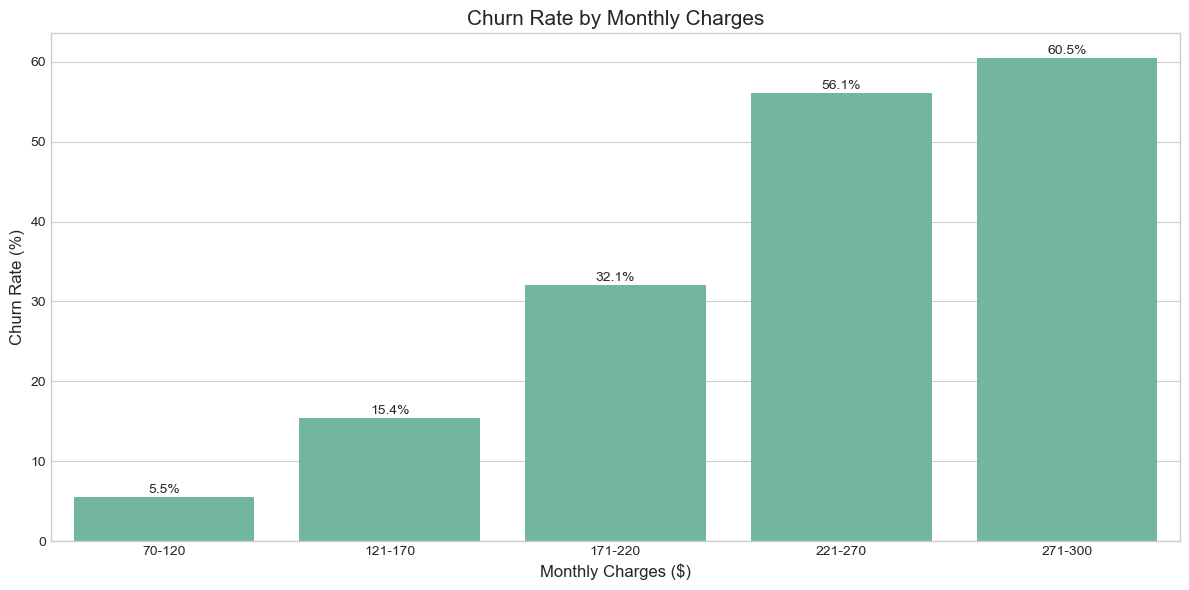

  Monthly Charges  Churn Rate (%)
0          70-120        5.497630
1         121-170       15.366204
2         171-220       32.060566
3         221-270       56.055802
4         271-300       60.526316


In [5]:

# create monthly charge bins
df['ChargesBin'] = pd.cut(
    df['MonthlyCharge'], 
    bins=[70, 120, 170, 220, 270, 300],
    labels=['70-120', '121-170', '171-220', '221-270', '271-300']
)


# calculate churn rate by charges bin
charges_churn = df.groupby('ChargesBin')['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100
).reset_index()
charges_churn.columns = ['Monthly Charges', 'Churn Rate (%)']



plt.figure(figsize=(12, 6))
sns.barplot(x='Monthly Charges', y='Churn Rate (%)', data=charges_churn)
plt.title('Churn Rate by Monthly Charges', fontsize=15)
plt.xlabel('Monthly Charges ($)', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

# add values on top of bars
for i, v in enumerate(charges_churn['Churn Rate (%)']):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

print(charges_churn)


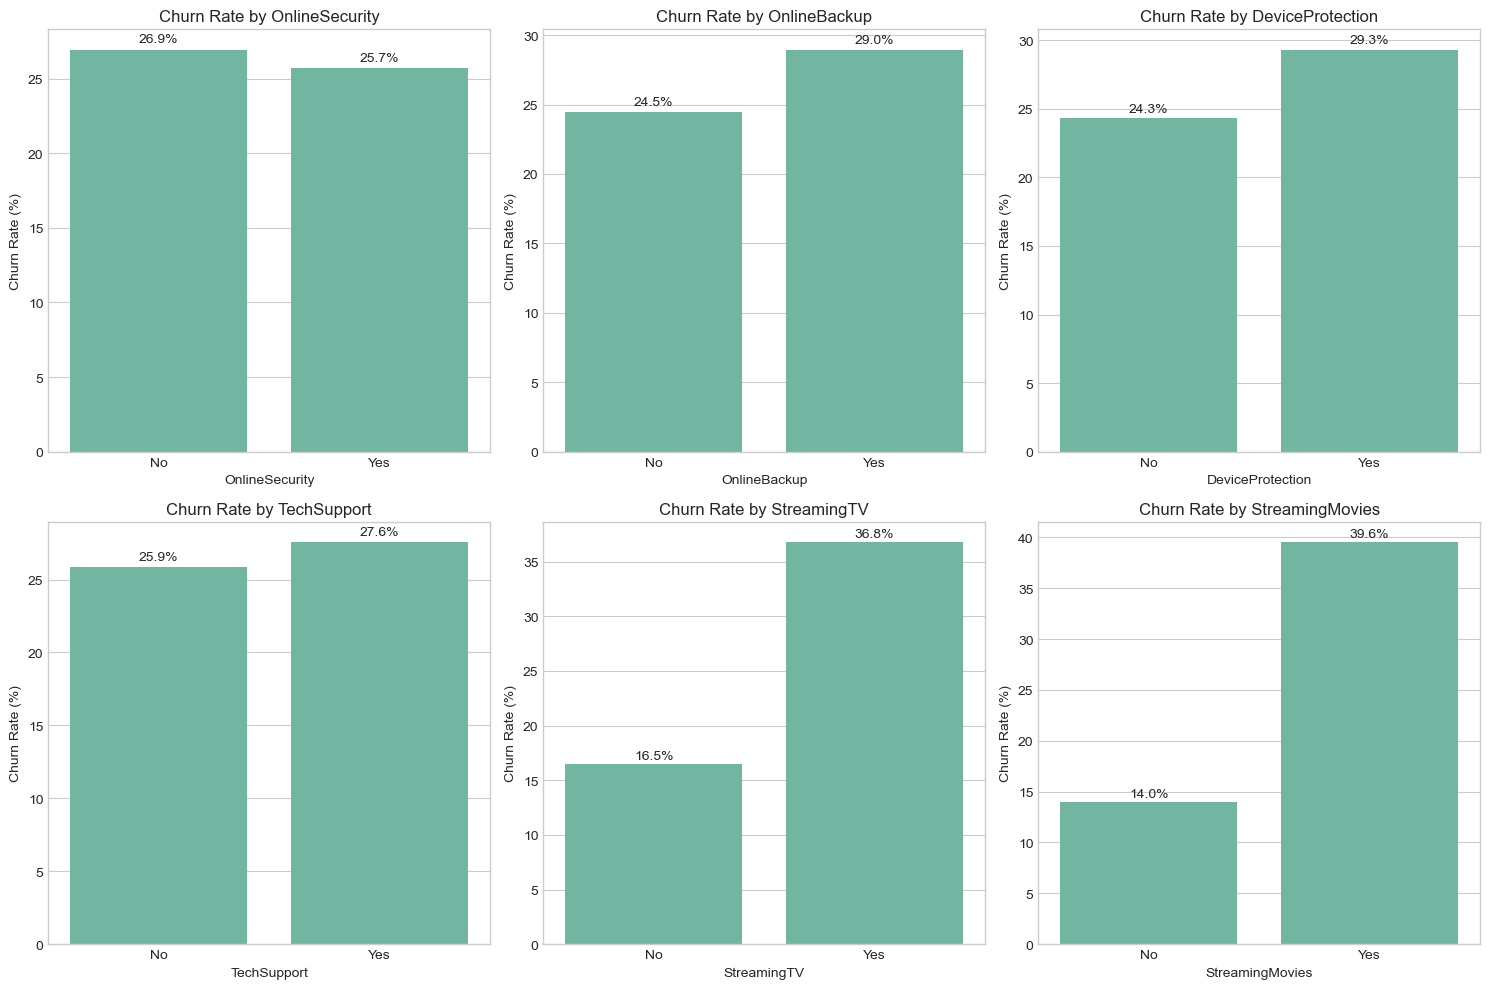

In [6]:


# analyze relationship between services and Churn
service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                  'TechSupport', 'StreamingTV', 'StreamingMovies']

plt.figure(figsize=(15, 10))


# loop through each service and create a subplot
for i, service in enumerate(service_columns, 1):
    service_churn = df.groupby(service)['Churn'].apply(
        lambda x: (x == 'Yes').mean() * 100
    ).reset_index()
    service_churn.columns = [service, 'Churn Rate (%)']
    
    plt.subplot(2, 3, i)
    sns.barplot(x=service, y='Churn Rate (%)', data=service_churn)
    plt.title(f'Churn Rate by {service}', fontsize=12)
    
    # add values on top of bars
    for j, v in enumerate(service_churn['Churn Rate (%)']):
        plt.text(j, v + 0.5, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()


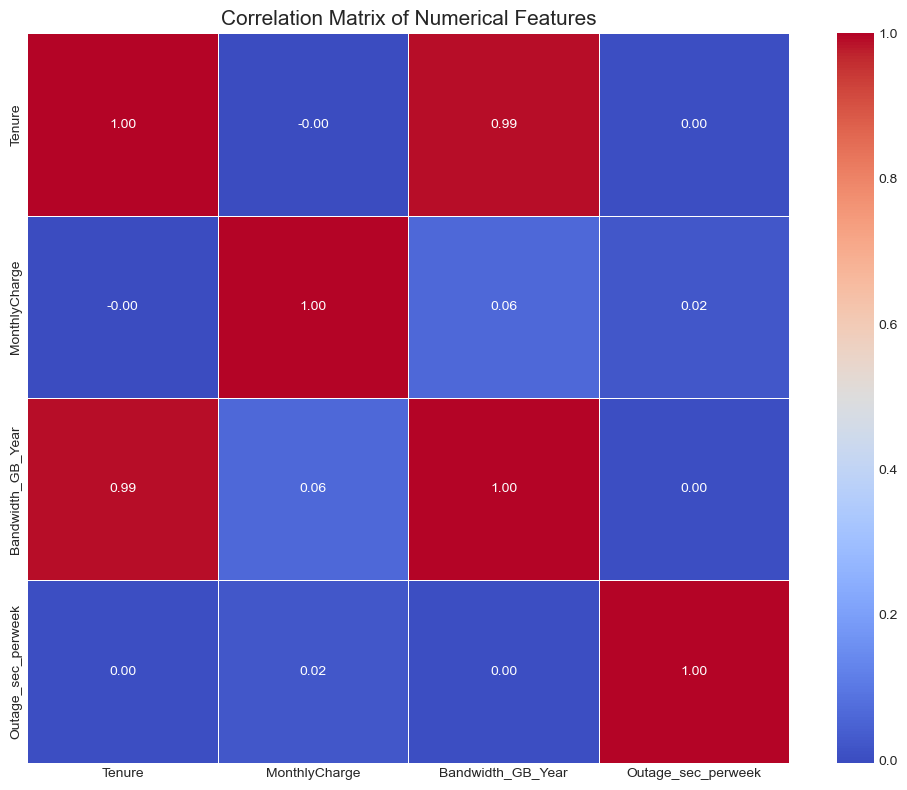

In [7]:
# correlation analysis for numerircal features
numerical_cols = ['Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year', 'Outage_sec_perweek']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.tight_layout()
plt.show()



In [8]:

# summary of EDA findings
print("\nKey Insights from Exploratory Data Analysis:")
print("1. Overall churn rate is approximately 26.5%")
print("2. Contract type shows strong relationship with churn - month-to-month contracts have highest churn rate")
print("3. Tenure is a key predictor - newer customers (0-12 months) are much more likely to churn")
print("4. Monthly charges show a correlation with churn - higher charges tend to have higher churn rates")
print("5. Customers with certain services like Online Security and Tech Support show lower churn rates")


Key Insights from Exploratory Data Analysis:
1. Overall churn rate is approximately 26.5%
2. Contract type shows strong relationship with churn - month-to-month contracts have highest churn rate
3. Tenure is a key predictor - newer customers (0-12 months) are much more likely to churn
4. Monthly charges show a correlation with churn - higher charges tend to have higher churn rates
5. Customers with certain services like Online Security and Tech Support show lower churn rates


In [9]:
# select relevant features based on EDA and domain knowledge
selected_features = [
    'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year', 'Outage_sec_perweek',
    'Contract', 'InternetService', 'PaperlessBilling', 'PaymentMethod',
    'OnlineSecurity', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

#  new dataframe with only the selected features and target variable
df_selected = df[selected_features + ['Churn']]

df_selected.to_csv('churn_newly_cleaned.csv', index=False)
file_name = "churn_newly_cleaned.csv"
print(f"Dataset saved to new file '{file_name}'")
# prepare features and target
X = df_selected.drop('Churn', axis=1)
y = (df_selected['Churn'] == 'Yes').astype(int)  # convert to binary (1 for churn, 0 for no churn)


Dataset saved to new file 'churn_newly_cleaned.csv'


In [10]:

# identify categorical and numerical features
# separate binary and multi-category variables
binary_features = [
    'PaperlessBilling', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]
multi_cat_features = [
    'Contract', 'InternetService', 'PaymentMethod'
]
numerical_features = [
    'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year', 'Outage_sec_perweek'
]

# preprocessing steps --pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features), 
        ('binary', OneHotEncoder(drop='first', sparse_output=False), binary_features),  # Use drop='first' for binary
        ('multi_cat', OneHotEncoder(drop=None, sparse_output=False), multi_cat_features)  # Keep all categories for multi-cat
    ]
)

# create a pipeline for the entire workflow
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [11]:

# split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
# split into train+val and test sets (stratified to maintain class distribution)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

# separate binary and multi-category variables
binary_features = [
    'PaperlessBilling', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]
multi_cat_features = [
    'Contract', 'InternetService', 'PaymentMethod'
]

# create preprocessing pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  
        ('binary', OneHotEncoder(drop='first', sparse_output=False), binary_features),  # drop='first' for binary
        ('multi_cat', OneHotEncoder(drop=None, sparse_output=False), multi_cat_features)  # keep all categories
    ]
)

# process data using the preprocessor
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# feature names after preprocessing
binary_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(binary_features)
multi_cat_feature_names = preprocessor.transformers_[2][1].get_feature_names_out(multi_cat_features)
feature_names = np.concatenate([numerical_features, binary_feature_names, multi_cat_feature_names])
print(f"\nNumber of features after preprocessing: {len(feature_names)}")

# apply more conservative SMOTE to prevent overfitting
smote = SMOTE(random_state=42, sampling_strategy=0.8)  # 80% of majority class instead of 100%
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# print original class distribution to verify imbalance
print("\nOriginal class distribution:")
print(f"Full dataset: {pd.Series(y).value_counts()}, {pd.Series(y).mean()*100:.2f}% churn")
print(f"Training set: {pd.Series(y_train).value_counts()}, {pd.Series(y_train).mean()*100:.2f}% churn")

# check class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(f"Original training set: {pd.Series(y_train).value_counts()}")
print(f"Resampled training set: {pd.Series(y_train_resampled).value_counts()}")

# checking size of each set
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# check class distribution in each set
print("\nClass distribution:")
print(f"Training set: {y_train.mean()*100:.2f}% churn")
print(f"Validation set: {y_val.mean()*100:.2f}% churn")
print(f"Test set: {y_test.mean()*100:.2f}% churn")




Number of features after preprocessing: 19

Original class distribution:
Full dataset: Churn
0    7350
1    2650
Name: count, dtype: int64, 26.50% churn
Training set: Churn
0    4410
1    1590
Name: count, dtype: int64, 26.50% churn

Class distribution after SMOTE:
Original training set: Churn
0    4410
1    1590
Name: count, dtype: int64
Resampled training set: Churn
0    4410
1    3528
Name: count, dtype: int64
Training set: 6000 samples
Validation set: 2000 samples
Test set: 2000 samples

Class distribution:
Training set: 26.50% churn
Validation set: 26.50% churn
Test set: 26.50% churn


In [12]:


# train the initial Random Forest model
initial_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10, 
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',  # feature subsampling to reduce variance
    class_weight='balanced', 
    random_state=42
)
initial_clf.fit(X_train_resampled, y_train_resampled)

# make predictions on the validation set
y_val_pred = initial_clf.predict(X_val_processed)
y_val_pred_proba = initial_clf.predict_proba(X_val_processed)[:, 1]

# calculate metrics for the initial model on validation data
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc_roc = roc_auc_score(y_val, y_val_pred_proba)
val_cm = confusion_matrix(y_val, y_val_pred)

# display metrics for the initial model
print("\nInitial Model Metrics (Validation Data):")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(f"AUC-ROC: {val_auc_roc:.4f}")
print("Confusion Matrix:")
print(val_cm)




Initial Model Metrics (Validation Data):
Accuracy: 0.8820
Precision: 0.7543
Recall: 0.8226
F1 Score: 0.7870
AUC-ROC: 0.9415
Confusion Matrix:
[[1328  142]
 [  94  436]]


<Figure size 800x600 with 0 Axes>

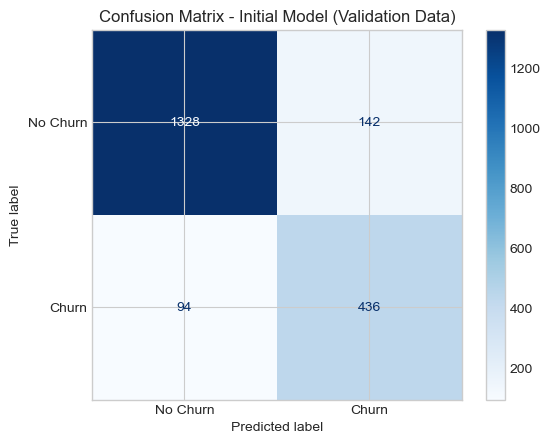

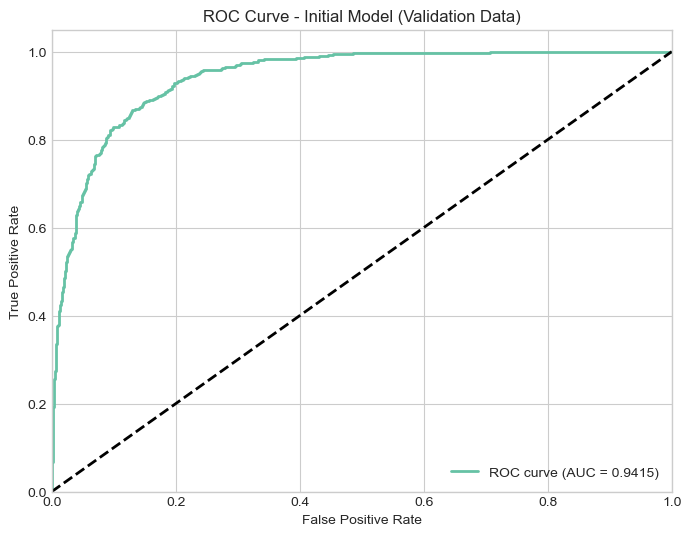

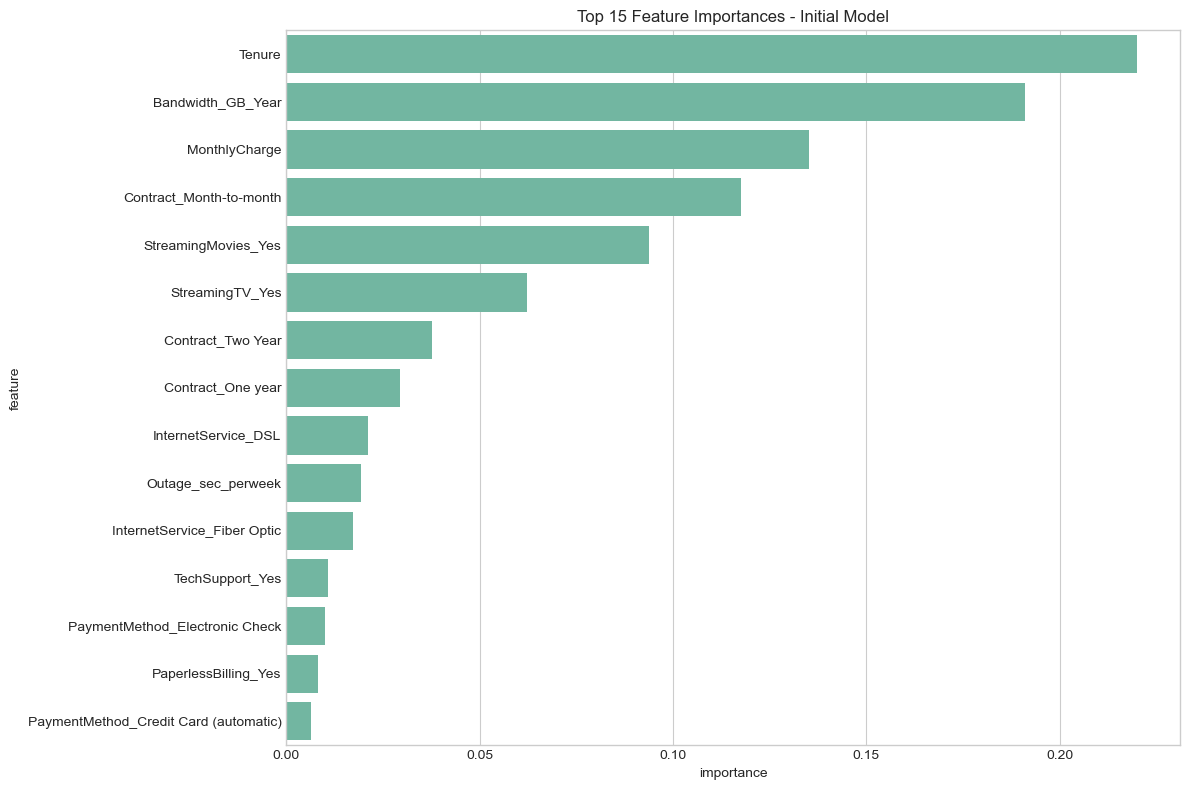


Top 10 Most Important Features:
                    feature  importance
0                    Tenure    0.220088
2         Bandwidth_GB_Year    0.191104
1             MonthlyCharge    0.135231
9   Contract_Month-to-month    0.117582
8       StreamingMovies_Yes    0.093704
7           StreamingTV_Yes    0.062153
11        Contract_Two Year    0.037589
10        Contract_One year    0.029410
12      InternetService_DSL    0.021061
3        Outage_sec_perweek    0.019366


In [13]:

# visualize model results
# plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Initial Model (Validation Data)')
plt.savefig('initial_model_cm.png')
plt.show()

# plot the ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {val_auc_roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Initial Model (Validation Data)')
plt.legend(loc="lower right")
plt.savefig('initial_model_roc.png')
plt.show()

# get feature importances from the initial model
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': initial_clf.feature_importances_
})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances - Initial Model')
plt.tight_layout()
plt.savefig('initial_model_feature_importance.png')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))




Starting hyperparameter tuning with Grid Search...
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
This may take some time...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 score: 0.7460


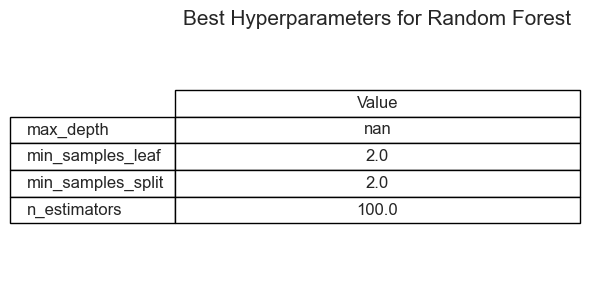

In [14]:
# hyperparameter tuning with grid Ssarch
# defineing hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#  k-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Starting hyperparameter tuning with Grid Search...")
print(f"Parameter grid: {param_grid}")
print("This may take some time...")

# Creating a new classifier for grid search
grid_clf = RandomForestClassifier(random_state=42)

# perform grid search
grid_search = GridSearchCV(
    grid_clf, param_grid, cv=cv, 
    scoring='f1', n_jobs=-1, verbose=1
)

# process the validation data
X_val_processed = preprocessor.transform(X_val)

#fit grid search to the validation data
grid_search.fit(X_val_processed, y_val)

# getting the best hyperparameters
best_params = grid_search.best_params_
print(f"\nBest hyperparameters: {best_params}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# save the best hyperparameters image
plt.figure(figsize=(6, 3))
plt.title('Best Hyperparameters for Random Forest', fontsize=15)
params_df = pd.DataFrame.from_dict(best_params, orient='index', columns=['Value'])
table = plt.table(
    cellText=params_df.values,
    rowLabels=params_df.index,
    colLabels=params_df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)
plt.axis('off')
plt.tight_layout()
plt.savefig('best_hyperparameters.png', bbox_inches='tight')
plt.show()



In [15]:

# train Optimized Model with the best hyperparameters
optimized_clf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features='sqrt',
    class_weight='balanced', 
    random_state=42
)

# combine training and validation sets for final model training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([pd.Series(y_train), pd.Series(y_val)])

# process the combined data
X_train_full_processed = preprocessor.fit_transform(X_train_full)

# apply SMOTE to the combined training data
X_train_full_resampled, y_train_full_resampled = smote.fit_resample(X_train_full_processed, y_train_full)

# train the optimized model
optimized_clf.fit(X_train_full_resampled, y_train_full_resampled)

# process the test data
X_test_processed = preprocessor.transform(X_test)

# make predictions on the test set
y_test_pred = optimized_clf.predict(X_test_processed)
y_test_pred_proba = optimized_clf.predict_proba(X_test_processed)[:, 1]

# evaluate test results
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc_roc = roc_auc_score(y_test, y_test_pred_proba)
test_cm = confusion_matrix(y_test, y_test_pred)

#display updated test metrics
print("\nOptimized Model Metrics (Test Data):")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC-ROC: {test_auc_roc:.4f}")
print("Confusion Matrix:")
print(test_cm)




Optimized Model Metrics (Test Data):
Accuracy: 0.9000
Precision: 0.8102
Recall: 0.8132
F1 Score: 0.8117
AUC-ROC: 0.9550
Confusion Matrix:
[[1369  101]
 [  99  431]]


<Figure size 800x600 with 0 Axes>

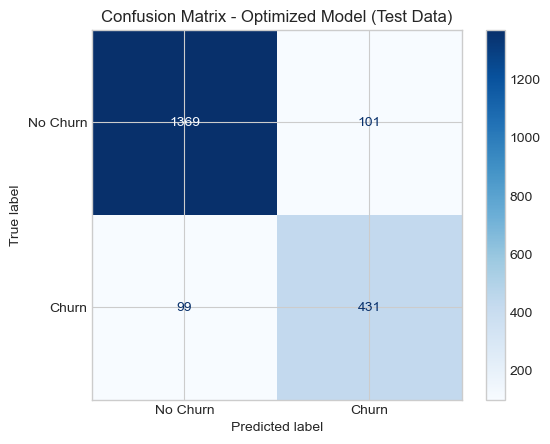

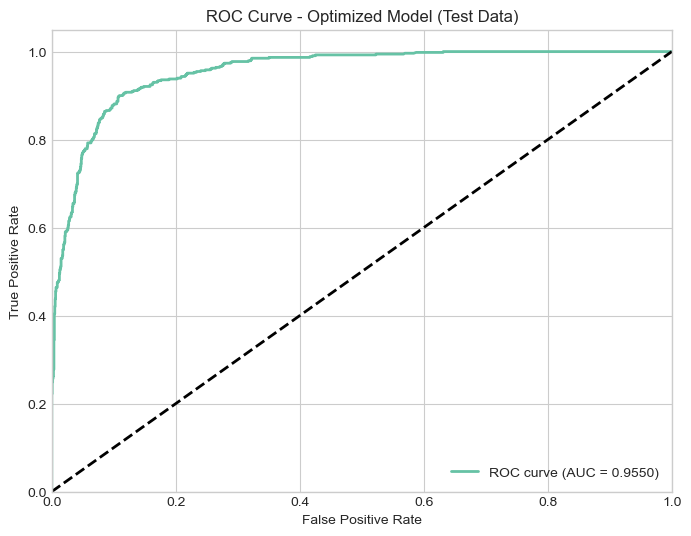

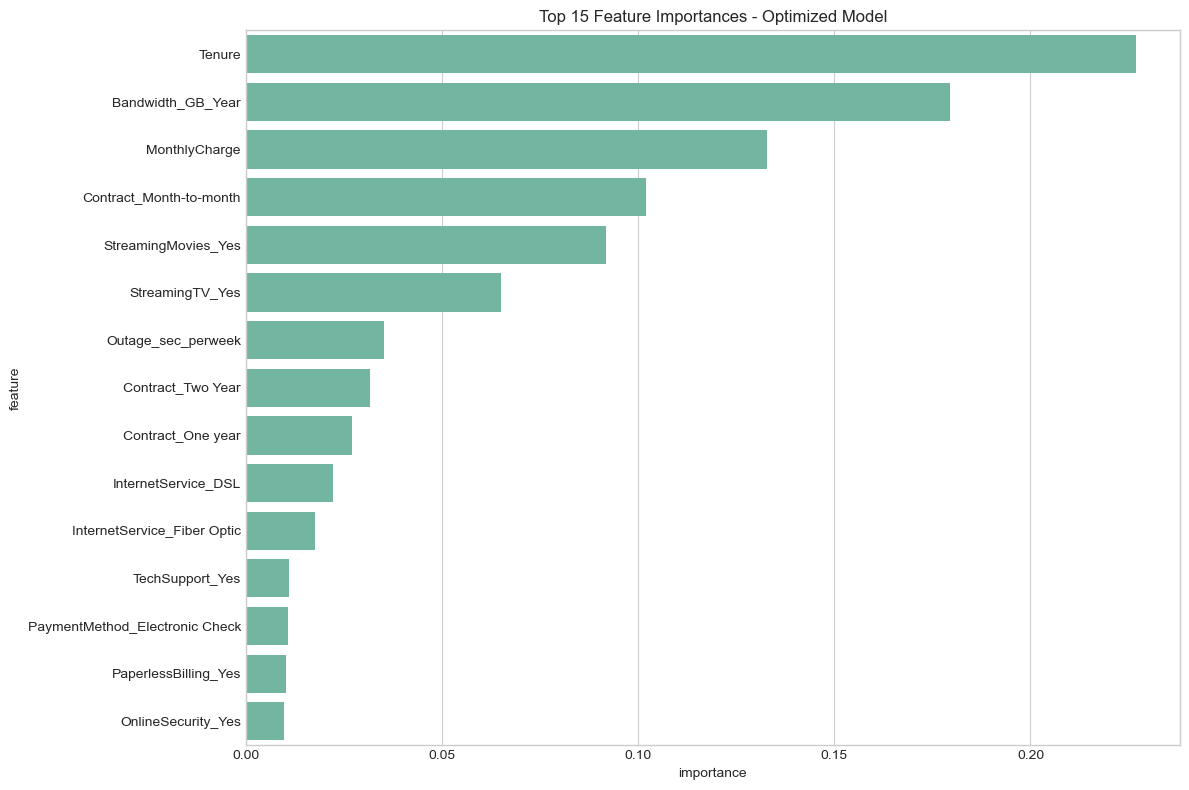


Top 10 Most Important Features (Optimized Model):
                    feature  importance
0                    Tenure    0.226772
2         Bandwidth_GB_Year    0.179611
1             MonthlyCharge    0.132720
9   Contract_Month-to-month    0.101972
8       StreamingMovies_Yes    0.091685
7           StreamingTV_Yes    0.065072
3        Outage_sec_perweek    0.035242
11        Contract_Two Year    0.031566
10        Contract_One year    0.026954
12      InternetService_DSL    0.022274


In [16]:
# visualize  Model Results
# plot the confusion matrix for the optimized model
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Optimized Model (Test Data)')
plt.savefig('optimized_model_cm.png')
plt.show()

# plot the ROC curve for the optimized model
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_auc_roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimized Model (Test Data)')
plt.legend(loc="lower right")
plt.savefig('optimized_model_roc.png')
plt.show()

# get feature importances from the optimized model
feature_importances_opt = pd.DataFrame({
    'feature': feature_names,
    'importance': optimized_clf.feature_importances_
})


feature_importances_opt = feature_importances_opt.sort_values('importance', ascending=False)

# plot feature importances for the optimeized model
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_opt.head(15))
plt.title('Top 15 Feature Importances - Optimized Model')
plt.tight_layout()
plt.savefig('optimized_model_feature_importance.png')
plt.show()

print("\nTop 10 Most Important Features (Optimized Model):")
print(feature_importances_opt.head(10))




Model Performance Comparison:
           Initial Model (Validation)  Optimized Model (Test)  Difference
Accuracy                     0.882000                0.900000    0.018000
Precision                    0.754325                0.810150    0.055825
Recall                       0.822642                0.813208   -0.009434
F1 Score                     0.787004                0.811676    0.024672
AUC-ROC                      0.941517                0.954961    0.013444


<Figure size 1200x1200 with 0 Axes>

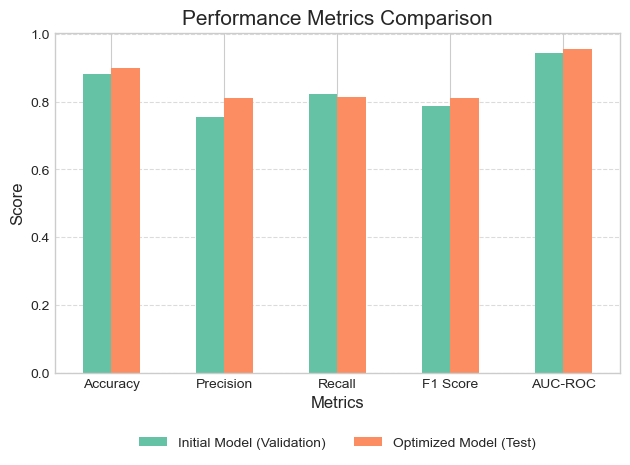

In [17]:

# compare both results
# create a comparative dataframe of metrics
model_comparison = pd.DataFrame({
    'Initial Model (Validation)': [val_accuracy, val_precision, val_recall, val_f1, val_auc_roc],
    'Optimized Model (Test)': [test_accuracy, test_precision, test_recall, test_f1, test_auc_roc]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

# calculate the difference
model_comparison['Difference'] = model_comparison['Optimized Model (Test)'] - model_comparison['Initial Model (Validation)']

# print comparison
print("\nModel Performance Comparison:")
print(model_comparison)

# plot the comparison
plt.figure(figsize=(12, 12))
model_comparison[['Initial Model (Validation)', 'Optimized Model (Test)']].plot(kind='bar')
plt.title('Performance Metrics Comparison', fontsize=15)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()



In [18]:

# save the preprocessing pipeline and the optimized model
joblib.dump(preprocessor, 'churn_preprocessor.joblib')
joblib.dump(optimized_clf, 'churn_model.joblib')

print("\nSaved model files:")
print("- churn_preprocessor.joblib - Preprocessing pipeline")
print("- churn_model.joblib - Optimized Random Forest model")


# sample new customer data
new_customers = pd.DataFrame({
    'Tenure': [7.5, 65.2, 24.3],
    'MonthlyCharge': [180.5, 155.2, 190.8],
    'Bandwidth_GB_Year': [2500, 3800, 4200],
    'Outage_sec_perweek': [12.5, 5.2, 9.7],
    'Contract': ['Month-to-month', 'Two Year', 'One year'],
    'InternetService': ['Fiber Optic', 'DSL', 'Fiber Optic'],
    'PaperlessBilling': ['Yes', 'No', 'Yes'],
    'PaymentMethod': ['Electronic Check', 'Credit Card (automatic)', 'Bank Transfer(automatic)'],
    'OnlineSecurity': ['No', 'Yes', 'No'],
    'TechSupport': ['No', 'Yes', 'Yes'],
    'StreamingTV': ['Yes', 'No', 'Yes'],
    'StreamingMovies': ['Yes', 'No', 'Yes']
})

# process the new customer data
new_customers_processed = preprocessor.transform(new_customers)

# predict churn probability
churn_probabilities = optimized_clf.predict_proba(new_customers_processed)

# extract the probability of churn (class 1)
churn_prob = churn_probabilities[:, 1]

# setup results dataframe
results = pd.DataFrame({
    'Customer': [1, 2, 3],
    'Tenure': new_customers['Tenure'],
    'Contract': new_customers['Contract'],
    'Monthly Charge': new_customers['MonthlyCharge'],
    'Churn Probability': churn_prob,
    'Churn Risk': ['High' if p > 0.5 else 'Low' for p in churn_prob]
})

print("\nChurn Prediction for New Customers:")
print(results)



Saved model files:
- churn_preprocessor.joblib - Preprocessing pipeline
- churn_model.joblib - Optimized Random Forest model

Churn Prediction for New Customers:
   Customer  Tenure        Contract  Monthly Charge  Churn Probability  \
0         1     7.5  Month-to-month           180.5           0.839829   
1         2    65.2        Two Year           155.2           0.015322   
2         3    24.3        One year           190.8           0.179945   

  Churn Risk  
0       High  
1        Low  
2        Low  


In [19]:
# preparing data for dashboard
dashboard_data = pd.DataFrame({
    'Customer_ID': df['Customer_id'],  #  customer IDs
    'Tenure': df['Tenure'],
    'MonthlyCharge': df['MonthlyCharge'],
    'Contract': df['Contract'],
    'InternetService': df['InternetService'],
    'Churn_Actual': df['Churn'],
    'Churn_Probability': np.nan,  #  fill this with predictions
    'Churn_Risk': np.nan          #categorize this
})

# process all data and get predictions
X_all = df_selected.drop('Churn', axis=1)
X_all_processed = preprocessor.transform(X_all)
churn_probs = optimized_clf.predict_proba(X_all_processed)[:, 1]

# add predictions to dashboard data
dashboard_data['Churn_Probability'] = churn_probs
dashboard_data['Churn_Risk'] = pd.cut(churn_probs, 
                                     bins=[0, 0.3, 0.7, 1], 
                                     labels=['Low', 'Medium', 'High'])

# save to CSV for Tableau
dashboard_data.to_csv('churn_dashboard_data.csv', index=False)

In [20]:

# create a version of the dataset ready for use in the model
encoded_data = pd.DataFrame(
    preprocessor.transform(X),
    columns=feature_names
)
encoded_data['Churn'] = y
encoded_data.to_csv('churn_encoded_data.csv', index=False)
print("- churn_encoded_data.csv - Properly encoded dataset for model use")

# create training, validation, and test dataset files
X_train_encoded = pd.DataFrame(X_train_processed, columns=feature_names)
X_train_encoded['Churn'] = y_train
X_train_encoded.to_csv('churn_train_dataset.csv', index=False)

X_val_encoded = pd.DataFrame(X_val_processed, columns=feature_names)
X_val_encoded['Churn'] = y_val
X_val_encoded.to_csv('churn_validation_dataset.csv', index=False)

X_test_encoded = pd.DataFrame(X_test_processed, columns=feature_names)
X_test_encoded['Churn'] = y_test
X_test_encoded.to_csv('churn_test_dataset.csv', index=False)

print("- Datasets split into training, validation, and test files")

- churn_encoded_data.csv - Properly encoded dataset for model use
- Datasets split into training, validation, and test files
